<a href="https://colab.research.google.com/github/RajeshMallik19/Project_Q/blob/student_dropout/6_Student_XAI_and_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries installed and imported.

--- Training the BiLSTM-CNN Model for Student Data ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model trained successfully.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Explaining prediction for student at index: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 3s 998us/step
Generating SHAP waterfall plot...


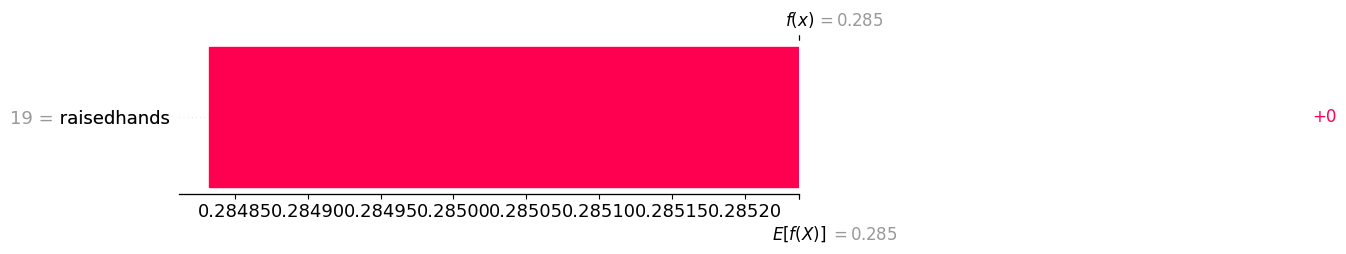


-------------------------------------------
--- Personalized Recommendation Report ---
Prediction: AT-RISK
Top Risk Factors: 

Recommended Interventions:
• General academic performance review with an advisor is recommended.
-------------------------------------------


In [3]:
# ===================================================================
# Part 0: Install and Import Libraries
# ===================================================================
!pip install shap
!pip install imbalanced-learn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import shap

print("Libraries installed and imported.")


# ===================================================================
# Part 1: Load Data and Retrain the Best Student Model (BiLSTM-CNN)
# ===================================================================
df = pd.read_csv('student_dropout_prepped.csv')

# Convert boolean columns to integers
bool_cols = df.select_dtypes(include='bool').columns
for col in bool_cols:
    df[col] = df[col].astype(int)

X = df.drop(columns=['at_risk'])
y = df['at_risk']
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.2, random_state=42, stratify=y
)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Reshape data for the model
X_train_reshaped = np.reshape(X_train_resampled, (X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print("\n--- Training the BiLSTM-CNN Model for Student Data ---")
dl_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
dl_model.compile(optimizer='adam', loss='binary_crossentropy')
dl_model.fit(X_train_reshaped, y_train_resampled, epochs=20, batch_size=32, verbose=0)
print("Model trained successfully.")


# ===================================================================
# Part 2: Explain Predictions with SHAP
# ===================================================================
def predict_fn(data):
    data_reshaped = np.reshape(data, (data.shape[0], 1, data.shape[1]))
    return dl_model.predict(data_reshaped)

explainer = shap.KernelExplainer(predict_fn, X_train[:50])

# Find a student in the test set that the model predicts is at high risk
test_predictions = predict_fn(X_test)
high_risk_indices = np.where(test_predictions > 0.5)[0]

if len(high_risk_indices) > 0:
    high_risk_index = high_risk_indices[0]
    print(f"\nExplaining prediction for student at index: {high_risk_index}")

    shap_values = explainer.shap_values(X_test[high_risk_index, :])

    print("Generating SHAP waterfall plot...")
    shap.waterfall_plot(shap.Explanation(values=shap_values[0],
                                         base_values=explainer.expected_value[0],
                                         data=X_test[high_risk_index, :],
                                         feature_names=X.columns.tolist()))
else:
    print("\nNo at-risk students found in the test sample to explain.")


# ===================================================================
# Part 3: Create the Personalized Student Recommendation Function
# ===================================================================
def get_student_recommendation(shap_values, column_names):
    feature_impacts = list(zip(column_names, shap_values))
    feature_impacts.sort(key=lambda x: x[1], reverse=True)
    top_drivers = [f for f, v in feature_impacts[:3] if v > 0]

    print("\n-------------------------------------------")
    print("--- Personalized Recommendation Report ---")
    print(f"Prediction: AT-RISK")
    print(f"Top Risk Factors: {', '.join(top_drivers)}")

    print("\nRecommended Interventions:")
    recommendations = []
    for feature in top_drivers:
        if 'StudentAbsenceDays_Under-7' in feature: # Note: In this dataset, a value of 0 for this means "Above-7"
            recommendations.append("• High absenteeism detected. Recommend meeting with student counselor to address potential issues.")
        elif 'raisedhands' in feature:
            recommendations.append("• Low class participation. Recommend teacher encouragement and engagement strategies.")
        elif 'VisITedResources' in feature:
            recommendations.append("• Low engagement with course materials. Suggest academic advisor follow-up to provide study resources.")
        elif 'ParentAnsweringSurvey_Yes' in feature: # A value of 0 means "No"
            recommendations.append("• Lack of parental engagement noted. Recommend scheduling a parent-teacher conference.")
        elif 'Discussion' in feature:
            recommendations.append("• Low participation in discussion groups. Suggest assigning collaborative projects.")

    if not recommendations:
        recommendations.append("• General academic performance review with an advisor is recommended.")

    for rec in recommendations:
        print(rec)
    print("-------------------------------------------")

# Run the recommendation engine if an at-risk student was found
if len(high_risk_indices) > 0:
    get_student_recommendation(shap_values[0], X.columns)